In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, log_loss
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
import torch.nn.functional as F

import warnings
warnings.filterwarnings('ignore')

In [5]:
# data = pd.read_csv('data_preprocessed/data_combined_4000.csv', index_col='Unnamed: 0')
data = pd.read_csv('data_preprocessed/data_new_3511.csv', index_col='Unnamed: 0')
data = data.loc[:2000, :]

In [6]:
X = data.drop(['Result'], axis=1)
y = data['Result']

In [4]:
red_cols = [col for col in data.columns if col.find('Red') > -1]
blue_cols = [col for col in data.columns if col.find('Blue') > -1]

data[red_cols]

,RedAge,RedHeightCms,RedReachCms,RedWeightLbs,RedWinsBySubmission,RedCurrentWinStreak,RedLosses,RedCurrentLoseStreak,RedAvgSigStrLanded,RedAvgSigStrPct,RedAvgSubAtt,RedAvgTDLanded,RedAvgTDPct,RedTotalRoundsFought,RedLongestWinStreak,RedWinsByDecision,RedWinsByKO/TKO,RedTimeSinceLastFight
1,30,185.42,195.58,170,5,6,0,0,4.1200,0.610,1.8000,1.4900,0.290,11,6,0,1,357
2,34,193.04,205.74,245,2,1,2,0,5.4900,0.600,0.5000,0.5800,0.210,33,7,3,4,462
3,30,177.80,177.80,145,1,0,2,1,2.3000,0.580,1.6000,3.4500,0.410,22,6,6,0,357
4,36,175.26,182.88,145,2,1,3,0,6.2500,0.460,1.0000,1.0000,0.410,17,3,2,1,252
5,34,193.04,195.58,205,1,1,4,0,4.8700,0.500,0.3000,0.3500,0.280,21,6,2,4,182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6508,30,190.50,200.66,264,7,1,4,0,10.3333,0.520,1.2667,0.8000,0.351,20,4,1,2,0
6512,24,182.88,193.04,170,5,0,3,1,4.5700,0.409,1.4444,1.3333,0.476,20,5,1,0,0
6518,26,193.04,195.58,238,0,4,0,0,4.6600,0.538,0.0000,0.0000,0.000,6,4,0,4,0
6521,28,170.18,177.80,155,1,0,5,2,2.5700,0.394,0.6000,3.4000,0.382,26,3,3,1,0


In [16]:
# # Отображение первых двух признаков
# plt.scatter(X.values[:, 4], X.values[:, 12], c=y)
# plt.xlabel('Признак 1')
# plt.ylabel('Признак 2')
# plt.title('Сгенерированные данные')
# plt.show()

In [7]:
test_size = int(len(X)*0.2)

X_train = X.iloc[test_size:, :]
y_train = y.iloc[test_size:]
X_test = X.iloc[:test_size, :]
y_test = y.iloc[:test_size]

In [8]:
scaler = StandardScaler().set_output(transform='pandas')
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
X_test

,RedAge,RedHeightCms,RedReachCms,RedWeightLbs,RedWinsBySubmission,RedCurrentWinStreak,RedLosses,RedCurrentLoseStreak,RedAvgSigStrLanded,RedAvgSigStrPct,...,BlueAvgTDLanded,BlueAvgTDPct,BlueTotalRoundsFought,BlueLongestWinStreak,RedWinsByDecision,RedWinsByKO/TKO,BlueWinsByDecision,BlueWinsByKO/TKO,RedTimeSinceLastFight,BlueTimeSinceLastFight
1,-0.326286,0.853074,1.147618,0.255915,2.055914,2.385047,-1.007107,-0.763606,-0.011960,2.004970,...,-0.520175,0.872537,0.264816,2.731183,-0.974412,-0.412870,1.382148,0.860000,0.678997,-0.272343
2,0.627524,1.657591,2.014547,2.331022,0.458219,-0.140317,-0.382735,-0.763606,1.067736,1.860395,...,-0.749148,1.252540,1.839295,0.732942,0.123129,0.785171,1.382148,2.512616,1.229581,-0.237441
3,-0.326286,0.048556,-0.369508,-0.435787,-0.074346,-0.645390,-0.382735,0.325003,-1.446302,1.571245,...,-0.734837,-0.552475,-0.588027,-0.765739,1.220670,-0.812218,-0.855954,-0.792616,0.678997,1.821761
4,1.104429,-0.219616,0.063956,-0.435787,0.458219,-0.140317,-0.070549,-0.763606,1.666692,-0.163659,...,-0.534486,0.017530,-0.063200,0.233381,-0.242718,-0.412870,-0.855954,1.410872,0.128413,-0.377048
5,0.627524,1.657591,1.147618,1.224299,-0.074346,-0.140317,0.241637,-0.763606,0.579115,0.414642,...,-0.741993,-0.504975,3.085758,0.233381,-0.242718,0.785171,0.039287,3.063488,-0.238642,-0.272343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382,0.865976,0.048556,-0.369508,-0.435787,-0.074346,-0.140317,-0.070549,-0.763606,2.541483,1.282094,...,0.596071,-0.124972,0.330419,0.233381,-0.242718,0.785171,0.486907,-0.792616,0.018297,4.020570
383,-1.041643,0.853074,0.930886,-0.435787,-0.606910,-0.645390,-0.694921,0.325003,1.847955,-0.741960,...,-1.071142,-1.739985,-0.981647,-0.765739,-0.974412,-0.412870,-0.855954,-0.241744,-0.201937,-1.075083
384,1.342881,0.316729,-0.369508,-0.159106,-0.074346,-0.140317,0.553823,-0.763606,0.389971,-0.308234,...,0.388564,-0.314973,-0.260010,-0.765739,-0.974412,-0.812218,-0.408334,-0.792616,-0.055115,0.670004
385,-0.803191,-0.219616,0.063956,-0.435787,-0.074346,-0.645390,0.241637,0.325003,-0.870989,-1.609412,...,0.138124,0.540034,0.920849,0.233381,0.488976,-0.013523,0.486907,0.309128,-0.238642,0.565298


### Загрузка данных

In [10]:
# Определение датасета
class FighterDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X.iloc[idx]
        y = self.y.iloc[idx]  # берем только первый столбец (класс)
        return {
            'x': torch.tensor(x, dtype=torch.float32),
            'y': torch.tensor(y, dtype=torch.long)
        }  
    
# Загрузка данных
X = X_train
y = y_train

# Создание датасета и даталоадера
# Создание датасета и даталоадера
train_dataset = FighterDataset(X_train, y_train)
test_dataset = FighterDataset(X_test, y_test)
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Базовая модель. 3 слоя

In [11]:
# Определение нейронной сети
class FighterNet(nn.Module):
    def __init__(self):
        super(FighterNet, self).__init__()
        self.fc1 = nn.Linear(36, 128)  # входной слой
        self.fc2 = nn.Linear(128, 64)  # скрытый слой
        self.fc3 = nn.Linear(64, 2)  # выходной слой 

        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)              

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # активация ReLU
        x = torch.relu(self.fc2(x))  # активация ReLU
        x = self.fc3(x)
        return x      

### Больше слоев

In [14]:
class FighterNet(nn.Module):
    def __init__(self):
        super(FighterNet, self).__init__()
        self.fc1 = nn.Linear(36, 128)  # входной слой
        self.fc2 = nn.Linear(128, 64)  # скрытый слой
        self.fc3 = nn.Linear(64, 32)  # скрытый слой
        self.fc4 = nn.Linear(32, 2)  # выходной слой

        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight) 
        nn.init.kaiming_normal_(self.fc3.weight) 

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # активация ReLU
        x = torch.relu(self.fc2(x))  # активация ReLU
        x = torch.relu(self.fc3(x))  # активация ReLU
        x = self.fc4(x)
        return x

### Добавляем дропаут

In [18]:
class FighterNet(nn.Module):
    def __init__(self):
        super(FighterNet, self).__init__()
        self.fc1 = nn.Linear(36, 128)  # входной слой
        self.dropout1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(128, 128)  # скрытый слой
        self.dropout2 = nn.Dropout(p=0.2)
        self.fc3 = nn.Linear(128, 64)  # скрытый слой
        self.dropout3 = nn.Dropout(p=0.2)
        self.fc4 = nn.Linear(64, 64)  # скрытый слой
        self.dropout4 = nn.Dropout(p=0.2)
        self.fc5 = nn.Linear(64, 32)  # скрытый слой
        self.dropout5 = nn.Dropout(p=0.2)
        self.fc6 = nn.Linear(32, 2)  # выходной слой   

    def forward(self, x):        
        x = torch.relu(self.fc1(x))  # активация ReLU
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))  # активация ReLU
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))  # активация ReLU
        x = self.dropout3(x)
        x = torch.relu(self.fc4(x))  # активация ReLU
        x = self.dropout4(x)
        x = torch.relu(self.fc5(x))  # активация ReLU
        x = self.dropout5(x)
        x = self.fc6(x)
        return x

### Разные функции активации

In [63]:
class FighterNet(nn.Module):
    def __init__(self):
        super(FighterNet, self).__init__()
        self.fc1 = nn.Linear(18, 128)  # входной слой
        self.fc2 = nn.Linear(128, 64)  # скрытый слой
        self.fc3 = nn.Linear(64, 2)  # выходной слой

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # функция активации sigmoid
        x = torch.sigmoid(self.fc2(x))  # функция активации sigmoid
        x = self.fc3(x)
        return x

### Тестируем модель

In [19]:
# Инициализация нейронной сети и оптимизатора
net = FighterNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

# Обучение нейронной сети
for epoch in range(40):
    for batch in train_dataloader:
        x = batch['x']
        y = batch['y']
        optimizer.zero_grad()
        outputs = net(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
    print(f'Эпоха {epoch+1}, потеря: {loss.item()}')

Эпоха 1, потеря: 0.7317323088645935
Эпоха 2, потеря: 0.6960639953613281
Эпоха 3, потеря: 0.6767908334732056
Эпоха 4, потеря: 0.6615883708000183
Эпоха 5, потеря: 0.6054925322532654
Эпоха 6, потеря: 0.6677284240722656
Эпоха 7, потеря: 0.7156793475151062
Эпоха 8, потеря: 0.6804764866828918
Эпоха 9, потеря: 0.7299185991287231
Эпоха 10, потеря: 0.8177666068077087
Эпоха 11, потеря: 0.4237637519836426
Эпоха 12, потеря: 0.6352171897888184
Эпоха 13, потеря: 0.5031958222389221
Эпоха 14, потеря: 0.8124336004257202
Эпоха 15, потеря: 0.8001732230186462
Эпоха 16, потеря: 0.4805442690849304
Эпоха 17, потеря: 1.2083981037139893
Эпоха 18, потеря: 0.42785024642944336
Эпоха 19, потеря: 0.48349979519844055
Эпоха 20, потеря: 0.613477349281311
Эпоха 21, потеря: 0.6099476218223572
Эпоха 22, потеря: 0.7829815745353699
Эпоха 23, потеря: 0.4726073443889618
Эпоха 24, потеря: 0.6279675364494324
Эпоха 25, потеря: 0.5622854828834534
Эпоха 26, потеря: 0.5545562505722046
Эпоха 27, потеря: 0.3869927227497101
Эпоха 28,

f1_score: 0.652
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.72      0.69       194
           1       0.64      0.57      0.61       167

    accuracy                           0.65       361
   macro avg       0.65      0.65      0.65       361
weighted avg       0.65      0.65      0.65       361



Text(0.5, 23.52222222222222, 'predicted value')

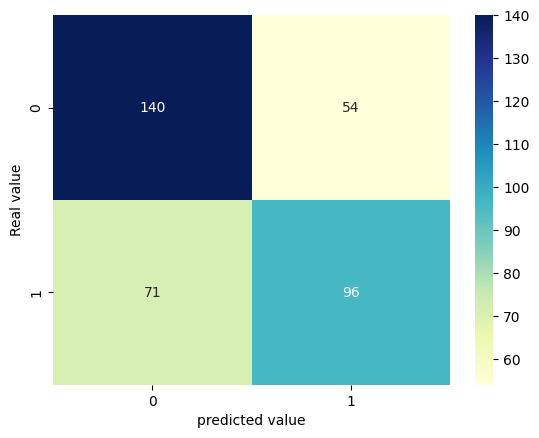

In [20]:
# Оценка модели на тестовых данных
net.eval()
test_y_pred_proba = []
test_y_true = []
test_y_pred = []
with torch.no_grad():
    for batch in test_dataloader:
        x = batch['x']
        y = batch['y']
        outputs = net(x)
        _, predicted = torch.max(outputs, 1)
        test_y_pred.extend(predicted.cpu().numpy())
        y_pred_proba = torch.nn.functional.softmax(outputs, dim=1)
        test_y_pred_proba.extend(y_pred_proba.cpu().numpy())
        test_y_true.extend(y.cpu().numpy())

# Матрица ошибок
print(f'f1_score: {f1_score(test_y_true, test_y_pred, average='weighted'):.3f}')
test_y_pred = np.argmax(test_y_pred_proba, axis=1)
test_cm = confusion_matrix(test_y_true, test_y_pred)
# Выводим метрики качества модели
print("Classification Report:")
print(classification_report(test_y_true, test_y_pred))


sns.heatmap(test_cm,  annot=True, fmt='d', cmap='YlGnBu')
plt.ylabel('Real value')
plt.xlabel('predicted value')

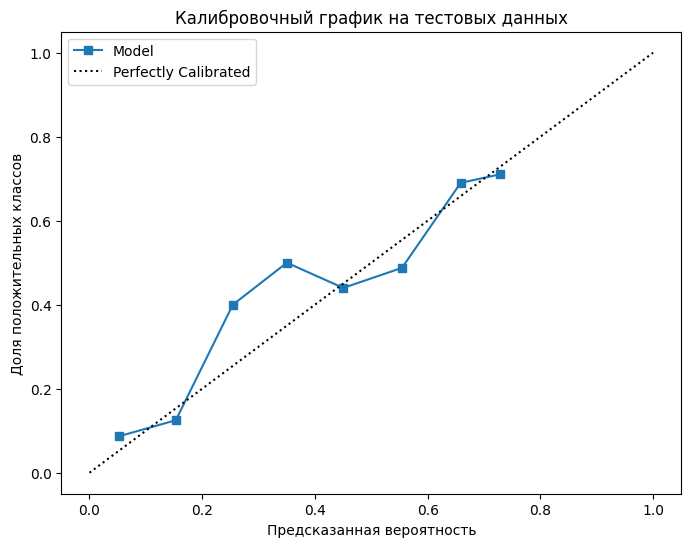

In [21]:
# Калибровочный график
plt.figure(figsize=(8, 6))
test_y_pred_proba_array = np.array(test_y_pred_proba)
fraction_of_positives, mean_predicted_value = calibration_curve(test_y_true, test_y_pred_proba_array[:, 1], n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives,'s-', label='Model')
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly Calibrated')
plt.xlabel('Предсказанная вероятность')
plt.ylabel('Доля положительных классов')
plt.title('Калибровочный график на тестовых данных')
plt.legend()
plt.show()

### Калибровка вероятностей

In [22]:
from sklearn.isotonic import IsotonicRegression

# Получение выходов модели
net.eval()
train_y_pred_proba = []
train_y_true = []
with torch.no_grad():
    for batch in train_dataloader:
        x = batch['x']
        y = batch['y']
        outputs = net(x)
        y_pred_proba = torch.nn.functional.softmax(outputs, dim=1)
        train_y_pred_proba.extend(y_pred_proba.cpu().numpy())
        train_y_true.extend(y.cpu().numpy())

# Откалибровка вероятностей при помощи изотонической регрессии
ir = IsotonicRegression(out_of_bounds='clip')
train_y_pred_proba = np.array(train_y_pred_proba)
train_y_true = np.array(train_y_true)

# Откалибровка вероятностей для каждого класса
for i in range(2):
    y_pred_proba_class = train_y_pred_proba[:, i]
    y_true_class = (train_y_true == i).astype(int)
    ir.fit(y_pred_proba_class, y_true_class)
    train_y_pred_proba[:, i] = ir.transform(y_pred_proba_class)

# Оценка модели на тестовых данных
test_y_pred_proba = []
test_y_true = []
with torch.no_grad():
    for batch in test_dataloader:
        x = batch['x']
        y = batch['y']
        outputs = net(x)
        y_pred_proba = torch.nn.functional.softmax(outputs, dim=1)
        test_y_pred_proba.extend(y_pred_proba.cpu().numpy())
        test_y_true.extend(y.cpu().numpy())

# Откалибровка вероятностей для тестовых данных
test_y_pred_proba = np.array(test_y_pred_proba)
for i in range(2):
    test_y_pred_proba[:, i] = ir.transform(test_y_pred_proba[:, i])

# Матрица ошибок
test_y_pred = np.argmax(test_y_pred_proba, axis=1)
print(f'f1_score: {f1_score(test_y_true, test_y_pred, average="weighted"):.3f}')

f1_score: 0.651


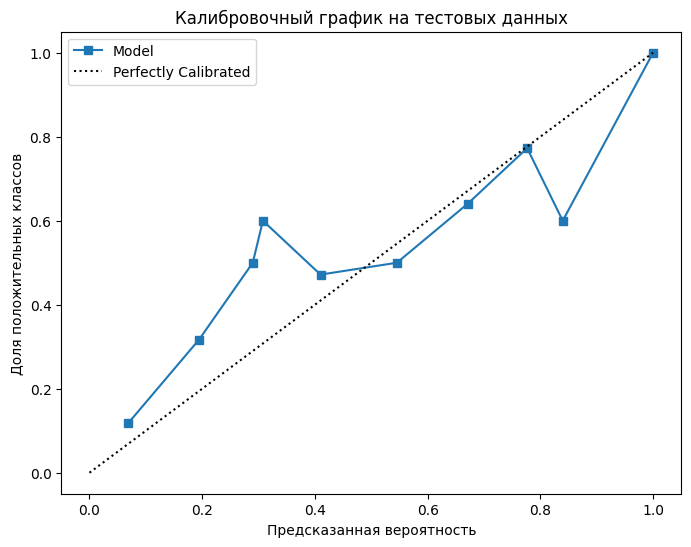

In [23]:
# Калибровочный график
plt.figure(figsize=(8, 6))
test_y_pred_proba_array = np.array(test_y_pred_proba)
fraction_of_positives, mean_predicted_value = calibration_curve(test_y_true, test_y_pred_proba_array[:, 1], n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives,'s-', label='Model')
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly Calibrated')
plt.xlabel('Предсказанная вероятность')
plt.ylabel('Доля положительных классов')
plt.title('Калибровочный график на тестовых данных')
plt.legend()
plt.show()

### Label Smoothing

In [36]:
# Определение функции потерь с label smoothing
class LabelSmoothingLoss(nn.Module):
    def __init__(self, alpha=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.alpha = alpha

    def forward(self, inputs, targets):
        n_classes = inputs.size(1)
        one_hot_targets = torch.zeros_like(inputs)
        one_hot_targets.scatter_(1, targets.long().unsqueeze(1), 1)
        smoothed_targets = (1 - self.alpha) * one_hot_targets + self.alpha / n_classes
        loss = nn.KLDivLoss()(inputs, smoothed_targets)
        return loss

In [37]:
net = FighterNet()
criterion = LabelSmoothingLoss(alpha=0.01)

# Обучение нейронной сети
for epoch in range(20):
    for batch in train_dataloader:
        x = batch['x']
        y = batch['y']
        optimizer.zero_grad()
        outputs = net(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
    print(f'Эпоха {epoch+1}, потеря: {loss.item()}')

Эпоха 1, потеря: 0.026346903294324875
Эпоха 2, потеря: -0.03280113264918327
Эпоха 3, потеря: -0.020941419526934624
Эпоха 4, потеря: -0.012922169640660286
Эпоха 5, потеря: -0.012362142093479633
Эпоха 6, потеря: -0.013911300338804722
Эпоха 7, потеря: -0.0018674569437280297
Эпоха 8, потеря: -0.0143467141315341
Эпоха 9, потеря: -0.0201384536921978
Эпоха 10, потеря: -0.058057088404893875
Эпоха 11, потеря: 0.011628474108874798
Эпоха 12, потеря: -0.004704952705651522
Эпоха 13, потеря: -0.02634809911251068
Эпоха 14, потеря: -0.01577446050941944
Эпоха 15, потеря: 0.004139324184507132
Эпоха 16, потеря: -0.029783746227622032
Эпоха 17, потеря: 0.02739846333861351
Эпоха 18, потеря: -0.03595627099275589
Эпоха 19, потеря: -0.03277275338768959
Эпоха 20, потеря: -0.013577623292803764


f1_score: 0.293
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       194
           1       0.46      1.00      0.63       167

    accuracy                           0.46       361
   macro avg       0.23      0.50      0.32       361
weighted avg       0.21      0.46      0.29       361



Text(0.5, 23.52222222222222, 'predicted value')

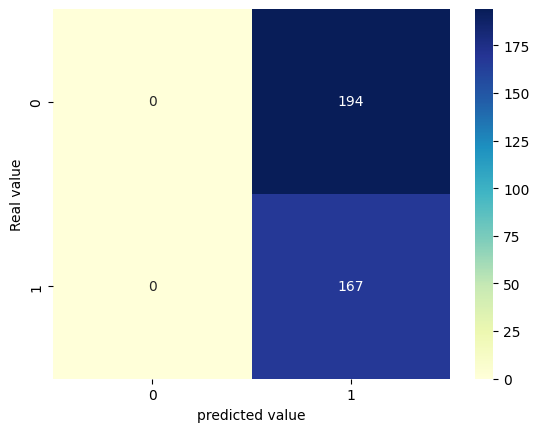

In [38]:
# Оценка модели на тестовых данных
net.eval()
test_y_pred_proba = []
test_y_true = []
test_y_pred = []
with torch.no_grad():
    for batch in test_dataloader:
        x = batch['x']
        y = batch['y']
        outputs = net(x)
        _, predicted = torch.max(outputs, 1)
        test_y_pred.extend(predicted.cpu().numpy())
        y_pred_proba = torch.nn.functional.softmax(outputs, dim=1)
        test_y_pred_proba.extend(y_pred_proba.cpu().numpy())
        test_y_true.extend(y.cpu().numpy())

# Матрица ошибок
print(f'f1_score: {f1_score(test_y_true, test_y_pred, average='weighted'):.3f}')
test_y_pred = np.argmax(test_y_pred_proba, axis=1)
test_cm = confusion_matrix(test_y_true, test_y_pred)
# Выводим метрики качества модели
print("Classification Report:")
print(classification_report(test_y_true, test_y_pred))


sns.heatmap(test_cm,  annot=True, fmt='d', cmap='YlGnBu')
plt.ylabel('Real value')
plt.xlabel('predicted value')

### Сиамская сеть

In [39]:
train_dataset = FighterDataset(X_train, y_train)
test_dataset = FighterDataset(X_test, y_test)
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [42]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.fc1 = nn.Linear(19, 128)  # Измените 38 на 20
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x1, x2):
        x1 = torch.relu(self.fc1(x1))
        x1 = torch.relu(self.fc2(x1))
        x1 = self.fc3(x1)

        x2 = torch.relu(self.fc1(x2))
        x2 = torch.relu(self.fc2(x2))
        x2 = self.fc3(x2)

        outputs = torch.sigmoid(x1 - x2)
        return outputs

In [43]:
# Обучение сиамской нейросети
model = SiameseNetwork()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(100):
    for batch in train_dataloader:
        x = batch['x']
        y = batch['y']
        optimizer.zero_grad()
        mid = len(x) // 2
        x1 = x[:mid]
        x2 = x[mid:mid + mid]
        outputs = model(x1, x2)
        loss = criterion(outputs, y[:mid].view(-1, 1).float())
        loss.backward()
        optimizer.step()
        print(f'Эпоха {epoch+1}, потеря: {loss.item()}') 

# Оценка сиамской нейросети
y_pred = []
for batch in test_dataloader:
    x = batch['x']
    output = model(x, x)  # используйте каждое входное данные как пару
    y_pred.extend((output > 0.5).int().cpu().numpy())

print(f'Точность: {accuracy_score(y_test, y_pred)}')
print(f'Полнота: {precision_score(y_test, y_pred)}')
print(f'Полнота: {recall_score(y_test, y_pred)}')
print(f'F1-мера: {f1_score(y_test, y_pred)}')

Эпоха 1, потеря: 0.7226750254631042
Эпоха 1, потеря: 0.9121410846710205
Эпоха 1, потеря: 0.6623425483703613
Эпоха 1, потеря: 0.8214619755744934
Эпоха 1, потеря: 0.7551918625831604
Эпоха 1, потеря: 0.6920650005340576
Эпоха 1, потеря: 0.7912954092025757
Эпоха 1, потеря: 0.8215950131416321
Эпоха 1, потеря: 0.7223433256149292
Эпоха 1, потеря: 0.7469351887702942
Эпоха 1, потеря: 0.7831440567970276
Эпоха 1, потеря: 0.8063768744468689
Эпоха 1, потеря: 0.8122696280479431
Эпоха 1, потеря: 0.7524821162223816
Эпоха 1, потеря: 0.7485930919647217
Эпоха 1, потеря: 0.6935082077980042
Эпоха 1, потеря: 0.6408390402793884
Эпоха 1, потеря: 0.8315709233283997
Эпоха 1, потеря: 0.7199030518531799
Эпоха 1, потеря: 0.8628289103507996
Эпоха 1, потеря: 0.8234405517578125
Эпоха 1, потеря: 0.7389788627624512
Эпоха 1, потеря: 0.7128870487213135
Эпоха 1, потеря: 0.6792712211608887
Эпоха 1, потеря: 0.743827223777771
Эпоха 1, потеря: 0.8111985325813293
Эпоха 1, потеря: 0.7031794786453247
Эпоха 1, потеря: 0.7085949182

### Эмбеддинг-нейросеть + Предсказательная нейросеть

In [52]:
# Инициализация моделей
class EmbeddingNetwork(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(EmbeddingNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, embedding_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class PredictionNetwork(nn.Module):
    def __init__(self, embedding_dim):
        super(PredictionNetwork, self).__init__()
        self.fc1 = nn.Linear(embedding_dim * 2, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x1, x2):
        x = torch.cat((x1, x2), dim=1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Инициализация моделей
embedding_network = EmbeddingNetwork(input_dim=19, embedding_dim=180)
prediction_network = PredictionNetwork(embedding_dim=180)

# Определение функции потерь и оптимизатора
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(list(embedding_network.parameters()) + list(prediction_network.parameters()), lr=0.001)

# Обучение моделей
for epoch in range(60):
    for batch in train_dataloader:
        x = batch['x']
        y = batch['y']

        # Разделение входных данных на пары бойцов
        x1 = x[:, :19]
        x2 = x[:, 19:]

        # Получение эмбеддингов
        embedding1 = embedding_network(x1)
        embedding2 = embedding_network(x2)

        # Предсказание
        outputs = prediction_network(embedding1, embedding2)

        # Расчет потерь
        loss = criterion(outputs, y.view(-1, 1).float())

        # Обратное распространение ошибок
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Эпоха {epoch+1}, потеря: {loss.item()}')

In [82]:
# Оценка модели на тестовой выборке
embedding_network.eval()
prediction_network.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for batch in test_dataloader:
        x = batch['x']
        y = batch['y']

        # Разделение входных данных на пары бойцов
        x1 = x[:, :18]
        x2 = x[:, 18:]

        # Получение эмбеддингов
        embedding1 = embedding_network(x1)
        embedding2 = embedding_network(x2)

        # Предсказание
        outputs = prediction_network(embedding1, embedding2)

        # Преобразование выходных данных в бинарные метки
        pred = torch.sigmoid(outputs) > 0.5
        y_pred.extend(pred.int().cpu().numpy())
        y_true.extend(y.int().cpu().numpy())

# Расчет F1-меры
from sklearn.metrics import f1_score
f1 = f1_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print(f'F1-мера: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

F1-мера: 0.5211
Accuracy: 0.5849
Precision: 0.5224
Recall: 0.5197


### Сиамская сеть + Label Smoothing

In [16]:
# Инициализация моделей
embedding_network = EmbeddingNetwork(input_dim=18, embedding_dim=180)
prediction_network = PredictionNetwork(embedding_dim=180)

class LabelSmoothingLoss(nn.Module):
    def __init__(self, alpha=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.alpha = alpha

    def forward(self, inputs, targets):
        n_classes = 2
        targets = targets.long()
        one_hot_targets = torch.zeros(targets.shape[0], n_classes, device=targets.device)
        one_hot_targets[range(targets.shape[0]), targets] = 1
        smoothed_targets = (1 - self.alpha) * one_hot_targets + self.alpha / n_classes
        inputs = torch.sigmoid(inputs)
        inputs = torch.cat((1 - inputs, inputs), dim=1)
        loss = nn.KLDivLoss()(inputs, smoothed_targets)
        return loss

criterion = LabelSmoothingLoss(alpha=0.01)
optimizer = optim.Adam(list(embedding_network.parameters()) + list(prediction_network.parameters()), lr=0.001)

# Обучение моделей
for epoch in range(40):
    for batch in train_dataloader:
        x = batch['x']
        y = batch['y']

        # Разделение входных данных на пары бойцов
        x1 = x[:, :18]
        x2 = x[:, 18:]

        # Получение эмбеддингов
        embedding1 = embedding_network(x1)
        embedding2 = embedding_network(x2)

        # Предсказание
        outputs = prediction_network(embedding1, embedding2)

        # Расчет потерь
        loss = criterion(outputs, y)

        # Обратное распространение ошибок
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Эпоха {epoch+1}, потеря: {loss.item()}')

Эпоха 1, потеря: -0.29546210169792175
Эпоха 2, потеря: -0.2954695224761963
Эпоха 3, потеря: -0.255839079618454
Эпоха 4, потеря: -0.2756251394748688
Эпоха 5, потеря: -0.2954511344432831
Эпоха 6, потеря: -0.3548354208469391
Эпоха 7, потеря: -0.27564486861228943
Эпоха 8, потеря: -0.39443352818489075
Эпоха 9, потеря: -0.29544153809547424
Эпоха 10, потеря: -0.3152115046977997
Эпоха 11, потеря: -0.2558518648147583
Эпоха 12, потеря: -0.31523144245147705
Эпоха 13, потеря: -0.33502182364463806
Эпоха 14, потеря: -0.31522753834724426
Эпоха 15, потеря: -0.2756395936012268
Эпоха 16, потеря: -0.3645785450935364
Эпоха 17, потеря: -0.31635257601737976
Эпоха 18, потеря: -0.4137059450149536
Эпоха 19, потеря: -0.3317684829235077
Эпоха 20, потеря: -0.343214213848114
Эпоха 21, потеря: -0.2927420735359192
Эпоха 22, потеря: -0.41419926285743713
Эпоха 23, потеря: -0.3152472972869873
Эпоха 24, потеря: -0.31533312797546387
Эпоха 25, потеря: -0.29539060592651367
Эпоха 26, потеря: -0.2718847393989563
Эпоха 27, по

In [17]:
# Оценка модели на тестовой выборке
embedding_network.eval()
prediction_network.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for batch in test_dataloader:
        x = batch['x']
        y = batch['y']

        # Разделение входных данных на пары бойцов
        x1 = x[:, :18]
        x2 = x[:, 18:]

        # Получение эмбеддингов
        embedding1 = embedding_network(x1)
        embedding2 = embedding_network(x2)

        # Предсказание
        outputs = prediction_network(embedding1, embedding2)

        # Преобразование выходных данных в бинарные метки
        pred = torch.sigmoid(outputs) > 0.5
        y_pred.extend(pred.int().cpu().numpy())
        y_true.extend(y.int().cpu().numpy())

# Расчет F1-меры
from sklearn.metrics import f1_score
f1 = f1_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print(f'F1-мера: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

F1-мера: 0.3686
Accuracy: 0.6082
Precision: 0.6232
Recall: 0.2617


### RNN

In [24]:
class MMADataSet(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = MMADataSet(X_train, y_train)
test_dataset = MMADataSet(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Базовая RNN

In [25]:
# Модель RNN
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.rnn.hidden_size).to(x.device)
        out, _ = self.rnn(x.unsqueeze(1), h0)
        out = self.fc(out[:, -1, :])
        return torch.sigmoid(out)

### Больше слоев

In [27]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.unsqueeze(1)  # добавить размерность 1 для длины последовательности
        h0 = torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size).to(x.device)
        c0 = torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size).to(x.device)
        out, _ = self.rnn(x, (h0, c0))
        out = out[:, -1, :]
        out = self.dropout(out)
        out = torch.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        return torch.sigmoid(out)

### Еще больше слоев

In [31]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.rnn1 = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True)
        self.rnn2 = nn.LSTM(hidden_dim, hidden_dim, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, output_dim)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.2)

    def forward(self, x):
        x = x.unsqueeze(1)
        h0 = torch.zeros(self.rnn1.num_layers, x.size(0), self.rnn1.hidden_size).to(x.device)
        c0 = torch.zeros(self.rnn1.num_layers, x.size(0), self.rnn1.hidden_size).to(x.device)
        out, _ = self.rnn1(x, (h0, c0))
        h1 = torch.zeros(self.rnn2.num_layers, out.size(0), self.rnn2.hidden_size).to(x.device)
        c1 = torch.zeros(self.rnn2.num_layers, out.size(0), self.rnn2.hidden_size).to(x.device)
        out, _ = self.rnn2(out, (h1, c1))
        out = out[:, -1, :]
        out = self.dropout1(out)
        out = torch.relu(self.fc1(out))
        out = self.dropout2(out)
        out = torch.relu(self.fc2(out))
        out = self.dropout3(out)
        out = self.fc3(out)
        return torch.sigmoid(out)

### Тестирование RNN

Epoch 1, Loss: 4.5476226806640625
Epoch 2, Loss: 4.725813865661621
Epoch 3, Loss: 4.82581090927124
Epoch 4, Loss: 4.780723571777344
Epoch 5, Loss: 4.802977085113525
Epoch 6, Loss: 4.754132270812988
Epoch 7, Loss: 4.788511753082275
Epoch 8, Loss: 4.859587669372559
Epoch 9, Loss: 4.790920257568359
Epoch 10, Loss: 4.812302589416504
Epoch 11, Loss: 4.823493480682373
Epoch 12, Loss: 4.830508708953857
Epoch 13, Loss: 4.823010444641113
Epoch 14, Loss: 4.811378479003906
Epoch 15, Loss: 4.783736228942871
Epoch 16, Loss: 4.831878662109375
Epoch 17, Loss: 4.738473415374756
Epoch 18, Loss: 4.76850700378418
Epoch 19, Loss: 4.771895408630371
Epoch 20, Loss: 4.800549030303955
Epoch 21, Loss: 4.785181999206543
Epoch 22, Loss: 4.842595100402832
Epoch 23, Loss: 4.768196105957031
Epoch 24, Loss: 4.795176982879639
Epoch 25, Loss: 4.784318923950195
Epoch 26, Loss: 4.815643310546875
Epoch 27, Loss: 4.804385185241699
Epoch 28, Loss: 4.862027168273926
Epoch 29, Loss: 4.782674789428711
Epoch 30, Loss: 4.757810

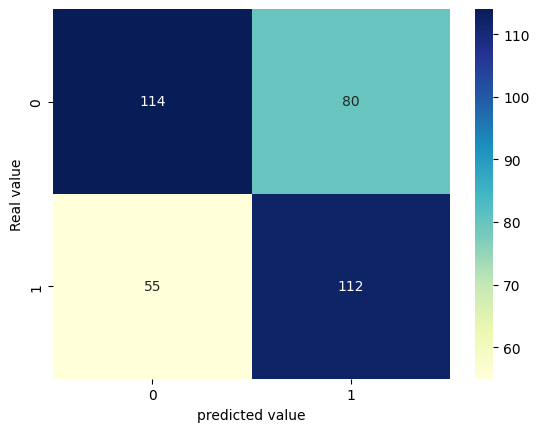

In [32]:
model = RNNModel(input_dim=X_train.shape[1], hidden_dim=64, output_dim=1)

# Обучение модели
criterion = nn.CrossEntropyLoss()
optimizer = optim.Rprop(model.parameters(), lr=0.01)

for epoch in range(30):
    for batch in train_loader:
        inputs, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Оценка модели
model.eval()
with torch.no_grad():
    total_correct = 0
    predicted_labels = []
    test_labels = []
    predicted_probas = []
    
    for batch in test_loader:
        inputs, labels = batch
        outputs = model(inputs)
        predicted = (outputs > 0.5).float()
        predicted_labels.extend(predicted.numpy().flatten())
        test_labels.extend(labels.numpy().flatten())
        predicted_probas.extend(outputs.numpy().flatten())

# Преобразовать списки в numpy массивы
predicted_labels = np.array(predicted_labels)
test_labels = np.array(test_labels)
predicted_probas = np.array(predicted_probas)

# Матрица ошибок
conf_mat = confusion_matrix(test_labels, predicted_labels)
print("Матрица ошибок:")
sns.heatmap(conf_mat,  annot=True, fmt='d', cmap='YlGnBu')
plt.ylabel('Real value')
plt.xlabel('predicted value')

# Classification report
print("\nClassification report:")
report = classification_report(test_labels, predicted_labels, output_dict=True)
print(report)

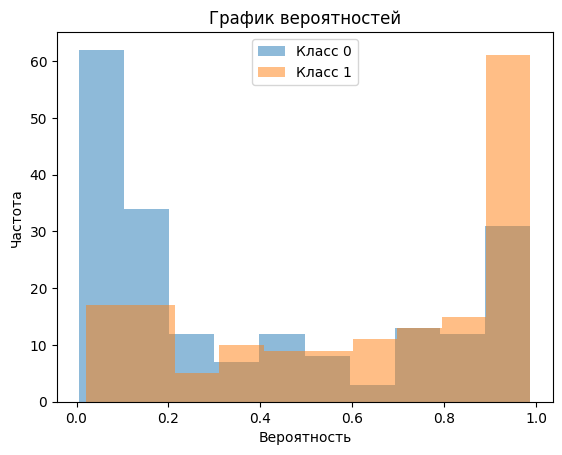

In [29]:
# Калибровочный график
plt.hist(predicted_probas[test_labels == 0], alpha=0.5, label='Класс 0')
plt.hist(predicted_probas[test_labels == 1], alpha=0.5, label='Класс 1')
plt.xlabel('Вероятность')
plt.ylabel('Частота')
plt.title('График вероятностей')
plt.legend()
plt.show()

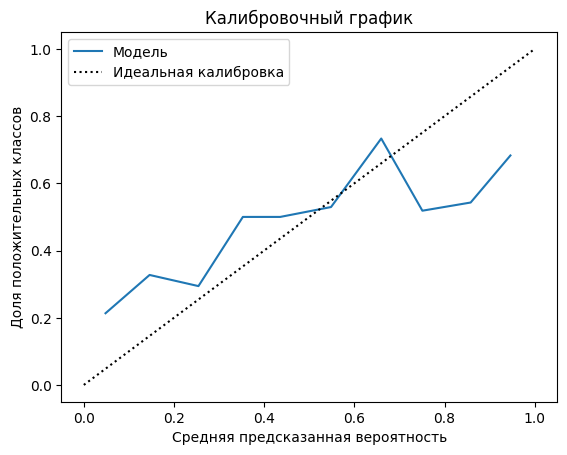

In [30]:
# Калибровочный график
from sklearn.calibration import calibration_curve
y_pred_proba = predicted_probas
y_true = test_labels

fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_pred_proba, n_bins=10)

plt.plot(mean_predicted_value, fraction_of_positives, '-', label='Модель')
plt.plot([0, 1], [0, 1], 'k:', label='Идеальная калибровка')
plt.xlabel('Средняя предсказанная вероятность')
plt.ylabel('Доля положительных классов')
plt.title('Калибровочный график')
plt.legend()
plt.show()

### Меняем количество нейронов в слое

In [112]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(RNNModel, self).__init__()
        self.rnn1 = nn.LSTM(input_dim, 64, num_layers=2, batch_first=True)
        self.rnn2 = nn.LSTM(64, 32, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(32, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_dim)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.2)

    def forward(self, x):
        x = x.unsqueeze(1)
        h0 = torch.zeros(self.rnn1.num_layers, x.size(0), self.rnn1.hidden_size).to(x.device)
        c0 = torch.zeros(self.rnn1.num_layers, x.size(0), self.rnn1.hidden_size).to(x.device)
        out, _ = self.rnn1(x, (h0, c0))
        h1 = torch.zeros(self.rnn2.num_layers, out.size(0), self.rnn2.hidden_size).to(x.device)
        c1 = torch.zeros(self.rnn2.num_layers, out.size(0), self.rnn2.hidden_size).to(x.device)
        out, _ = self.rnn2(out, (h1, c1))
        out = out[:, -1, :]
        out = self.dropout1(out)
        out = torch.relu(self.fc1(out))
        out = self.dropout2(out)
        out = torch.relu(self.fc2(out))
        out = self.dropout3(out)
        out = self.fc3(out)
        return torch.sigmoid(out)

### Тестирование RNN

f1_score: 0.5675013680709302

Классификационный отчет:
              precision    recall  f1-score   support

           0       0.62      0.62      0.62       496
           1       0.50      0.50      0.50       381

    accuracy                           0.57       877
   macro avg       0.56      0.56      0.56       877
weighted avg       0.57      0.57      0.57       877



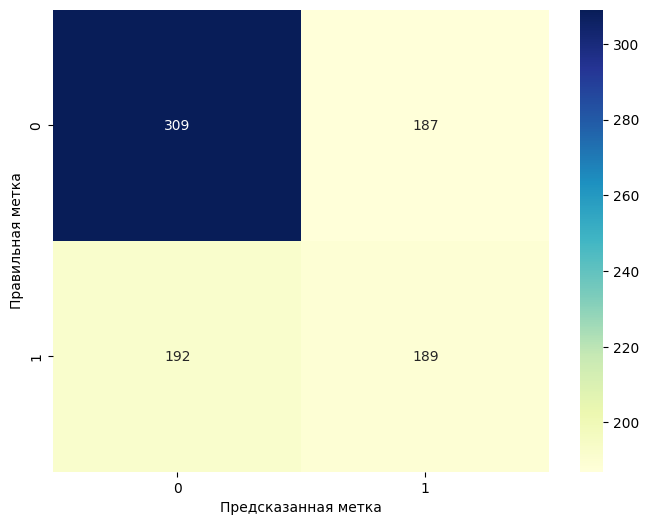

In [113]:
# Определение модели
import torch.optim.rprop


model = RNNModel(input_dim=19, output_dim=2)

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Обучение модели
for epoch in range(60):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, labels = batch
        labels = labels[:, None]  # добавляем новый размерность
        labels = torch.cat((1 - labels, labels), dim=1)  # преобразуем в бинарный формат
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    # print(f'Эпоха {epoch+1}, потеря: {total_loss / len(train_loader)}')

# Оценка модели на тестовой выборке
model.eval()
test_loss = 0
correct = 0
predicted_labels = []
test_labels = []
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        labels = labels[:, None]  # добавляем новый размерность
        labels = torch.cat((1 - labels, labels), dim=1)  # преобразуем в бинарный формат
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        predicted = torch.argmax(outputs, dim=1)  # получаем индекс максимальной вероятности
        correct += (predicted == torch.argmax(labels, dim=1)).sum().item()
        predicted_labels.extend(predicted.cpu().numpy())
        test_labels.extend(torch.argmax(labels, dim=1).cpu().numpy())

# Матрица ошибок
conf_mat = confusion_matrix(test_labels, predicted_labels)
print(f'f1_score: {f1_score(test_labels, predicted_labels, average='weighted')}')

# Классификационный отчет
print("\nКлассификационный отчет:")
print(classification_report(test_labels, predicted_labels))

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="YlGnBu")
plt.xlabel("Предсказанная метка")
plt.ylabel("Правильная метка")
plt.show()

### Гибридная RNN

**Создаем датасеты с боями по каждому отдельному бойцу, у которого больше 5 боев в UFC**

In [ ]:
# Выберем все бои, где участовали бойцы минимум с 1 боем за плечами
fights_with_stats = data[((data['RedWins'] + data['RedLosses']) >= 1) & ((data['BlueWins'] + data['BlueLosses']) >= 1)]

# Составим список всех бойцов
fighter_names = set(fights_with_stats.loc[(fights_with_stats['RedWins'] + fights_with_stats['RedLosses']) >= 5, 'RedFighter'].unique()) & \
                set(fights_with_stats.loc[(fights_with_stats['BlueWins'] + fights_with_stats['BlueLosses']) >= 5, 'BlueFighter'].unique())

print(f'Общее число бойцов, у которых более 5 боев: {len(fighter_names)}')

In [ ]:
fights_with_stats

In [71]:
# Теперь составим для каждого бойца список из последних 5 боев с его участием
fighter_fights = {}
for fighter in fighter_names:
    fighter_fights[fighter] = fights_with_stats.loc[(fights_with_stats['RedFighter'] == fighter) | \
                             (fights_with_stats['BlueFighter'] == fighter)].head()

In [ ]:
pd.DataFrame(fighter_fights['Ilia Topuria'])

In [82]:
# Определение датасета
class FighterDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X.iloc[idx]
        y = self.y.iloc[idx]  # берем только первый столбец (класс)
        return {
            'x': torch.tensor(x, dtype=torch.float32),
            'y': torch.tensor(y, dtype=torch.long)
        }  

In [95]:
train_dataset = FighterDataset(X_train, y_train)
test_dataset = FighterDataset(X_test, y_test)
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [211]:
# Создание общей модели
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()        
        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.rnn.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.rnn.hidden_size).to(x.device)
        out, _ = self.rnn(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out   

# Обучение общей модели
model = RNNModel(input_dim=39, hidden_dim=128, output_dim=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
for epoch in range(10):
    for batch in train_dataloader:
        x = batch['x'].unsqueeze(1)  # добавляем временную размерность
        y = batch['y']
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

In [ ]:
# Оценка модели на тестовой выборке
model.eval()
test_loss = 0
correct = 0
y_pred = []
y_true = []
with torch.no_grad():
    for batch in test_dataloader:
        x = batch['x'].unsqueeze(1)  # добавляем временную размерность
        y = batch['y']
        outputs = model(x)
        loss = criterion(outputs, y)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y).sum().item()
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(y.cpu().numpy())

accuracy = correct / len(test_dataset)
f1 = f1_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

print(f'Tочность на тестовой выборке: {accuracy:.4f}')
print(f'F1-мера на тестовой выборке: {f1:.4f}')
print(f'Precision на тестовой выборке: {precision:.4f}')
print(f'Recall на тестовой выборке: {recall:.4f}')
print(f'Средняя потеря на тестовой выборке: {test_loss / len(test_dataloader):.4f}')

Fine-tune на бойцах с 5+ боями в лиге

In [213]:
class FighterDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        return {
            'x': x,
            'y': y
        }

In [214]:
# Для каждого бойца создайте отдельный датасет
fighter_datasets = {}
fighter_dataloaders = {}
for fighter, fights in fighter_fights.items():
    fighter_df = pd.DataFrame(fights)
    # Нормализуйте данные и преобразуйте их в тензоры
    fighter_X = fighter_df.drop(['RedFighter', 'BlueFighter', 'Result'], axis=1)
    fighter_y = fighter_df['Result']
    fighter_X = torch.tensor(fighter_X.values, dtype=torch.float32)
    fighter_y = torch.tensor(fighter_y.values, dtype=torch.long)
    # Создайте датасет для fine-tuning
    fighter_dataset = FighterDataset(fighter_X, fighter_y)
    # Создайте загрузчик данных для fine-tuning
    fighter_dataloader = DataLoader(fighter_dataset, batch_size=32, shuffle=True)
    # Сохраните датасет и загрузчик в словарях
    fighter_datasets[fighter] = fighter_dataset
    fighter_dataloaders[fighter] = fighter_dataloader

In [215]:
import copy

# Обучение fine-tuned моделей
fighter_models = {}
for fighter, fighter_dataloader in fighter_dataloaders.items():
    # Создайте копию основной модели
    fighter_model = copy.deepcopy(model)
    # Определите критерий и оптимизатор
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(fighter_model.parameters(), lr=0.001)
    # Обучите fine-tuned модель
    for epoch in range(5):
        for batch in fighter_dataloader:
            x = batch['x'].unsqueeze(1)  # добавляем временную размерность
            y = batch['y']
            optimizer.zero_grad()
            outputs = fighter_model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
    # Сохраните fine-tuned модель в словаре
    fighter_models[fighter] = fighter_model

### Объединение общей и fine-tuned моделей

1. Объединение весов моделей

Этот код объединяет веса основной модели и всех fine-tuned моделей, взвешивая каждую модель по количеству данных, на которых она была обучена. Это позволяет более точно учитывать разницу в размерах данных для каждого бойца.

In [216]:
# Объединение весов моделей
combined_model = model  # основная модель
beta = torch.tensor(1.0)  # экспоненциальный коэффициент
for fighter, fighter_model in fighter_models.items():
    for k in combined_model.state_dict():
        combined_model.state_dict()[k] = (1 / (1 + torch.exp(-beta))) * combined_model.state_dict()[k] + (torch.exp(-beta) / (1 + torch.exp(-beta))) * fighter_model.state_dict()[k]

In [ ]:
# Оценка полученной модели на тестовой выборке
combined_model.eval()
test_loss = 0
correct = 0
y_pred = []
y_true = []
with torch.no_grad():
    for batch in test_dataloader:
        x = batch['x'].unsqueeze(1)  # добавляем временную размерность
        y = batch['y']
        outputs = combined_model(x)
        loss = nn.CrossEntropyLoss()(outputs, y)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y).sum().item()
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(y.cpu().numpy())

accuracy = correct / len(test_dataset)
f1 = f1_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

print(f'Tочность на тестовой выборке: {accuracy:.4f}')
print(f'F1-мера на тестовой выборке: {f1:.4f}')
print(f'Precision на тестовой выборке: {precision:.4f}')
print(f'Recall на тестовой выборке: {recall:.4f}')
print(f'Средняя потеря на тестовой выборке: {test_loss / len(test_dataloader):.4f}')

2. Переобучение основной модели на данных, которые были использованы для fine-tuning

In [218]:
# Создание нового датасета
combined_X = torch.cat([dataset.X for dataset in fighter_datasets.values()])
combined_y = torch.cat([dataset.y for dataset in fighter_datasets.values()])
combined_dataset = FighterDataset(combined_X, combined_y)

# Создание загрузчика данных
combined_dataloader = DataLoader(combined_dataset, batch_size=32, shuffle=True)

# Переобучение основной модели
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
for epoch in range(5):
    for batch in combined_dataloader:
        x = batch['x'].unsqueeze(1)  # добавляем временную размерность
        y = batch['y']
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

In [ ]:
# Оценка полученной модели на тестовой выборке
model.eval()
test_loss = 0
correct = 0
y_pred = []
y_true = []
with torch.no_grad():
    for batch in test_dataloader:
        x = batch['x'].unsqueeze(1)  # добавляем временную размерность
        y = batch['y']
        outputs = model(x)
        loss = nn.CrossEntropyLoss()(outputs, y)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y).sum().item()
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(y.cpu().numpy())

accuracy = correct / len(test_dataset)
f1 = f1_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

print(f'Tочность на тестовой выборке: {accuracy:.4f}')
print(f'F1-мера на тестовой выборке: {f1:.4f}')
print(f'Precision на тестовой выборке: {precision:.4f}')
print(f'Recall на тестовой выборке: {recall:.4f}')
print(f'Средняя потеря на тестовой выборке: {test_loss / len(test_dataloader):.4f}')

3. Методы ensemble: stacking и bagging, чтобы объединить результаты fine-tuned моделей и создать новую общую модель.

In [222]:
class RNNModelWrapper(BaseEstimator):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        # код для обучения модели
        pass

    def predict(self, X):
        # код для предсказания
        X_tensor = torch.tensor(X, dtype=torch.float32)
        X_tensor = X_tensor.unsqueeze(1)  # добавляем временную размерность
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X_tensor)
            _, predicted = torch.max(outputs, 1)
            return predicted.numpy()

In [ ]:
# Stacking
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression


# Создание списка моделей
models = list(fighter_models.values())

# Создание списка оберток для моделей
wrappers = [RNNModelWrapper(model) for model in models]

# Создание списка предсказаний
predictions = []
for model in models:
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
        X_test_tensor = X_test_tensor.unsqueeze(1)  # добавляем временную размерность
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs, 1)
        predictions.append(predicted.numpy())

# Создание списка уникальных имен для моделей
model_names = [f'model_{i}' for i in range(len(models))]

# Создание stacking-модели
estimators = list(zip(model_names, wrappers))
stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

# Обучение stacking-модели
stacking_model.fit(np.array(predictions).T, y_test.values)